### The core purpose of this analysis is to answer the following question: 

Are some artists “viral breakout artists” achieving unusually high popularity despite having relatively small follower bases, while others are “legacy giants” maintaining massive followings but exhibiting only average or declining popularity? To address this, we use a residual-based framework that separates short-term momentum from long-term audience size. 

Artist popularity is modeled as a function of follower count to establish an expected level of popularity for artists of similar scale. The difference between an artist’s actual popularity and this expected value, referred to as the residual, captures whether an artist is overperforming or underperforming relative to their following size. 

By standardising these residuals, we identify statistically rare positive residual spikes as viral breakout behavior and near-zero residuals among high-follower artists as legacy stability. This approach allows us to distinguish genuine breakout momentum from popularity driven purely by scale and to classify artists based on performance relative to expectation rather than raw metrics alone

In [1]:
import pandas as pd
import numpy as np

In [2]:
dataframe = pd.read_csv("spotify_data clean.csv")
dataframe.head()

,track_id,track_name,track_number,track_popularity,explicit,artist_name,artist_popularity,artist_followers,artist_genres,album_id,album_name,album_release_date,album_total_tracks,album_type,track_duration_min
0,3EJS5LyekDim1Tf5rBFmZl,Trippy Mane (ft. Project Pat),4,0,True,Diplo,77,2812821,moombahton,5QRFnGnBeMGePBKF2xTz5z,"d00mscrvll, Vol. 1",31/10/2025,9,album,1.55
1,1oQW6G2ZiwMuHqlPpP27DB,OMG!,1,0,True,Yelawolf,64,2363438,"country hip hop, southern hip hop",4SUmmwnv0xTjRcLdjczGg2,OMG!,31/10/2025,1,single,3.07
2,7mdkjzoIYlf1rx9EtBpGmU,Hard 2 Find,1,4,True,Riff Raff,48,193302,NaN,3E3zEAL8gUYWaLYB9L7gbp,Hard 2 Find,31/10/2025,1,single,2.55
3,67rW0Zl7oB3qEpD5YWWE5w,Still Get Like That (ft. Project Pat & Starrah),8,30,True,Diplo,77,2813710,moombahton,5QRFnGnBeMGePBKF2xTz5z,"d00mscrvll, Vol. 1",31/10/2025,9,album,1.69
4,15xptTfRBrjsppW0INUZjf,ride me like a harley,2,0,True,Rumelis,48,8682,dark r&b,06FDIpSHYmZAZoyuYtc7kd,come closer / ride me like a harley,30/10/2025,2,single,2.39


In [3]:
dataframe.shape

(8582, 15)

In [4]:
dataframe.describe()

,track_number,track_popularity,artist_popularity,artist_followers,album_total_tracks,track_duration_min
count,8582.000000,8582.000000,8582.000000,8.582000e+03,8582.000000,8582.000000
mean,5.772547,52.356211,69.730016,2.403472e+07,13.789443,3.492805
std,6.052792,23.816076,19.645979,3.803180e+07,11.887131,1.057970
min,1.000000,0.000000,0.000000,0.000000e+00,1.000000,0.070000
25%,1.000000,39.000000,60.000000,4.623200e+05,6.000000,2.880000
50%,4.000000,58.000000,74.000000,6.105547e+06,13.000000,3.445000
75%,9.000000,71.000000,84.000000,2.725255e+07,17.000000,3.990000
max,102.000000,99.000000,100.000000,1.455421e+08,181.000000,13.510000


In [5]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8582 entries, 0 to 8581
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   track_id            8582 non-null   object 
 1   track_name          8582 non-null   object 
 2   track_number        8582 non-null   int64  
 3   track_popularity    8582 non-null   int64  
 4   explicit            8582 non-null   bool   
 5   artist_name         8579 non-null   object 
 6   artist_popularity   8582 non-null   int64  
 7   artist_followers    8582 non-null   int64  
 8   artist_genres       5221 non-null   object 
 9   album_id            8582 non-null   object 
 10  album_name          8582 non-null   object 
 11  album_release_date  8582 non-null   object 
 12  album_total_tracks  8582 non-null   int64  
 13  album_type          8582 non-null   object 
 14  track_duration_min  8582 non-null   float64
dtypes: bool(1), float64(1), int64(5), object(8)
memory usag

In [6]:
dataframe.nunique()

track_id              8582
track_name            7462
track_number            54
track_popularity        98
explicit                 2
artist_name           2547
artist_popularity       96
artist_followers      3740
artist_genres          661
album_id              5205
album_name            4869
album_release_date    2384
album_total_tracks      82
album_type               3
track_duration_min     647
dtype: int64

In [7]:
dataframe.isna().sum()

track_id                 0
track_name               0
track_number             0
track_popularity         0
explicit                 0
artist_name              3
artist_popularity        0
artist_followers         0
artist_genres         3361
album_id                 0
album_name               0
album_release_date       0
album_total_tracks       0
album_type               0
track_duration_min       0
dtype: int64

In [8]:
check_dups = dataframe.duplicated(subset = "artist_name").sum()
check_dups

6034

In [9]:
#Grouping by artist to remove duplicates and aggrigate their stats
artist_data = dataframe.groupby(["artist_name"]).agg({
    'track_popularity': 'max',      # Peak success
    'artist_followers': 'max',      # Total fanbase
    'artist_popularity': 'max'      # Overall artist score
})
artist_data

,track_popularity,artist_followers,artist_popularity
artist_name,,,
$uicideboy$,63,8957416,83
'Ery Noice,15,11720,25
(((()))),23,49519,51
*NSYNC,79,3088613,69
-,45,714,28
...,...,...,...
攬佬SKAI ISYOURGOD,62,298654,64
時瀬高等学校箏曲部,36,2625,22
桑原まこ,0,346,12


In [10]:
artist_data.isna().sum()

track_popularity     0
artist_followers     0
artist_popularity    0
dtype: int64

In [11]:
# converting attributes to numerical type
artist_data["artist_followers"] = pd.to_numeric(artist_data["artist_followers"], errors='coerce').fillna(0)
artist_data["artist_popularity"] = pd.to_numeric(artist_data["artist_popularity"], errors='coerce').fillna(0)

In [14]:

from sklearn.linear_model import HuberRegressor



# Transform number of followers
artist_data["log_followers"] = np.log1p(artist_data["artist_followers"])

#Fit baseline (robust) 
X = artist_data[["log_followers"]].values
y = artist_data["artist_popularity"].values
model = HuberRegressor().fit(X, y)

artist_data["pop_expected"] = model.predict(X)

#Residuals + robust z
artist_data["residual"] = artist_data["artist_popularity"] - artist_data["pop_expected"]

med = artist_data["residual"].median()
mad = (artist_data["residual"] - med).abs().median()
robust_sigma = 1.4826 * mad if mad > 0 else artist_data["residual"].std(ddof=0)

artist_data["z"] = (artist_data["residual"] - med) / (robust_sigma if robust_sigma > 0 else 1.0)

#Quantile bands for followers
q30 = artist_data["artist_followers"].quantile(0.30)
q85 = artist_data["artist_followers"].quantile(0.85)

low = artist_data["artist_followers"] <= q30
high = artist_data["artist_followers"] >= q85

#setting Labels
artist_data["artist_segment"] = "Stable/Normal"

artist_data.loc[low & (artist_data["z"] >= 2) & (artist_data["artist_popularity"] >= 70), "artist_segment"] = "Viral/One-hit candidate"
artist_data.loc[high & (artist_data["z"].abs() < 1), "artist_segment"] = "Legacy"
artist_data.loc[high & (artist_data["z"] <= -1), "artist_segment"] = "Declining legacy"
artist_data.loc[(~low) & (~high) & (artist_data["z"] >= 2), "artist_segment"] = "Rising"


In [15]:
artist_data

,track_popularity,artist_followers,artist_popularity,log_followers,pop_expected,residual,z,artist_segment
artist_name,,,,,,,,
$uicideboy$,63,8957416,83,16.007992,74.869272,8.130728,1.253332,Stable/Normal
'Ery Noice,15,11720,25,9.369137,37.409266,-12.409266,-1.931746,Stable/Normal
(((()))),23,49519,51,10.810132,45.540135,5.459865,0.839169,Stable/Normal
*NSYNC,79,3088613,69,14.943233,68.861324,0.138676,0.014027,Stable/Normal
-,45,714,28,6.572283,21.627900,6.372100,0.980627,Stable/Normal
...,...,...,...,...,...,...,...,...
攬佬SKAI ISYOURGOD,62,298654,64,12.607044,55.679285,8.320715,1.282793,Stable/Normal
時瀬高等学校箏曲部,36,2625,22,7.873217,28.968475,-6.968475,-1.088059,Stable/Normal
桑原まこ,0,346,12,5.849325,17.548582,-5.548582,-0.867880,Stable/Normal


In [16]:
artist_data.nunique()

track_popularity       97
artist_followers     2511
artist_popularity      95
log_followers        2511
pop_expected         2511
residual             2545
z                    2545
artist_segment          4
dtype: int64

### Visualising the Viral artists whose popularity is greater than or equal to 70

In [17]:

viral_artists = artist_data[
    (artist_data["z"] >= 2) &
    (artist_data["artist_popularity"] >= 70)
].sort_values("z", ascending=False)

viral_artists[[
    "artist_followers",
    "artist_popularity",
    "residual",
    "z"
]].head(20)


,artist_followers,artist_popularity,residual,z
artist_name,,,,
Olivia Dean,1524283,88,23.123425,3.578207
Chrystal,87184,70,21.268130,3.290512
Disco Lines,275333,75,19.779476,3.059670
MOLIY,197500,73,19.654161,3.040238
DJ Japa NK,282947,75,19.625558,3.035803
EsDeeKid,253650,74,19.242309,2.976373
WizTheMc,226566,73,18.879457,2.920107
Ely Oaks,190171,72,18.867532,2.918258
Rumi,220991,72,18.020036,2.786839


In [19]:
viral_artists[["artist_followers", "artist_popularity"]].describe()


,artist_followers,artist_popularity
count,2.500000e+01,25.000000
mean,9.676426e+05,75.920000
std,1.135652e+06,5.384546
min,8.718400e+04,70.000000
25%,2.536500e+05,72.000000
50%,3.506620e+05,74.000000
75%,8.445580e+05,77.000000
max,3.777019e+06,88.000000


In [20]:
artist_data[["artist_followers", "artist_popularity"]].describe()


,artist_followers,artist_popularity
count,2.547000e+03,2547.000000
mean,3.303236e+06,53.710640
std,9.630244e+06,19.916615
min,0.000000e+00,0.000000
25%,3.212850e+04,42.000000
50%,4.324660e+05,58.000000
75%,2.359747e+06,68.000000
max,1.455421e+08,100.000000


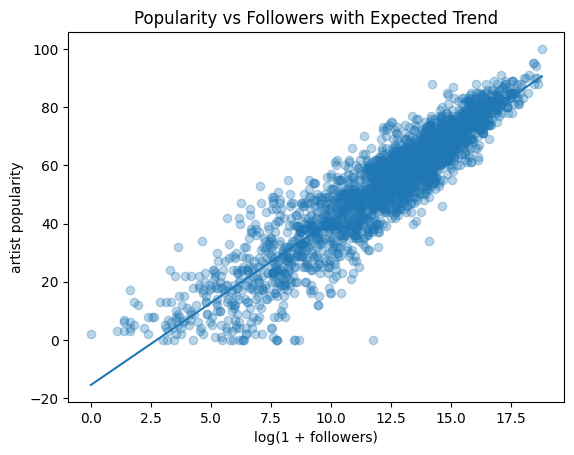

In [21]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(
    artist_data["log_followers"],
    artist_data["artist_popularity"],
    alpha=0.3
)

# expected popularity line
order = np.argsort(artist_data["log_followers"])
plt.plot(
    artist_data["log_followers"].iloc[order],
    artist_data["pop_expected"].iloc[order]
)

plt.xlabel("log(1 + followers)")
plt.ylabel("artist popularity")
plt.title("Popularity vs Followers with Expected Trend")
plt.show()


This plot shows the relationship between artist popularity and follower count on a log-transformed scale, along with the learned expected popularity trend. A strong positive relationship is evident, indicating that artists with larger follower bases tend to have higher popularity on average.

The fitted trend line represents the expected popularity for a given follower size and serves as the baseline against which individual artists are evaluated. Most artists cluster closely around this line, suggesting that popularity is largely predictable from audience size for the majority of cases.

Artists that appear well above the expected trend are outperforming expectations and are candidates for viral or breakout behavior, while those below the line are underperforming relative to their follower base. This plot provides the foundational justification for using residuals to separate momentum-driven popularity from scale-driven popularity.

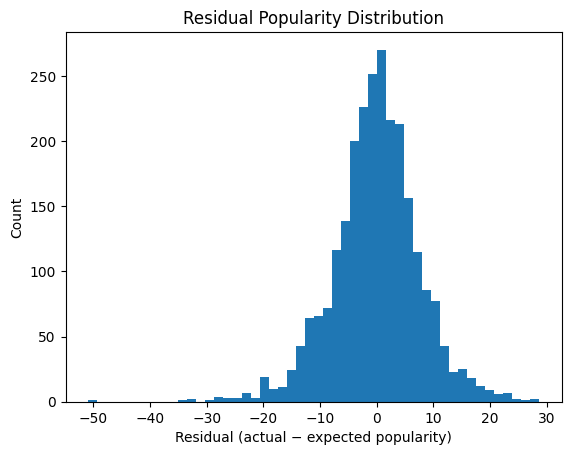

In [23]:
plt.figure()
plt.hist(artist_data["residual"], bins=50)
plt.xlabel("Residual (actual − expected popularity)")
plt.ylabel("Count")
plt.title("Residual Popularity Distribution")
plt.show()


This histogram shows the distribution of residual popularity, defined as the difference between an artist’s actual popularity and the popularity expected given their follower count.

The distribution is sharply centered around zero, indicating that for most artists, popularity closely matches what would be expected based on audience size. This confirms that follower count explains a large portion of popularity for the majority of artists.

The distribution is asymmetric, with a thin but extended positive tail. These high positive residuals represent rare cases where artists significantly outperform expectations, corresponding to viral or breakout behavior. The sparsity of this tail demonstrates that virality is uncommon rather than a normal fluctuation.

The negative side of the distribution is broader, suggesting that underperformance relative to expected popularity is more common than extreme overperformance. This aligns with typical artist lifecycles, where decline is more frequent than sudden breakout.

Overall, the residual distribution supports the interpretation of virality as an outlier event and validates the use of residual-based metrics to distinguish viral artists from stable or declining ones.

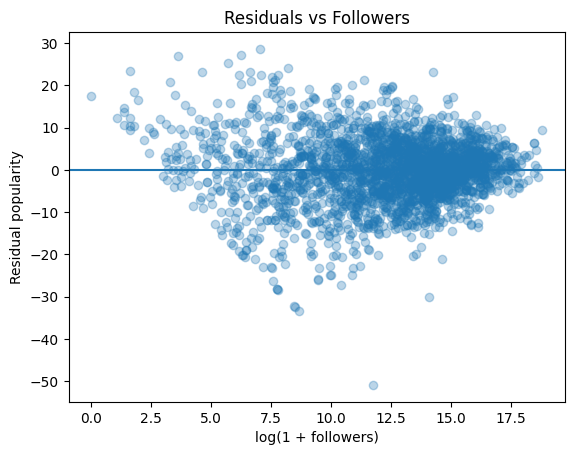

In [24]:
plt.figure()
plt.scatter(
    artist_data["log_followers"],
    artist_data["residual"],
    alpha=0.3
)

plt.axhline(0)
plt.xlabel("log(1 + followers)")
plt.ylabel("Residual popularity")
plt.title("Residuals vs Followers")
plt.show()


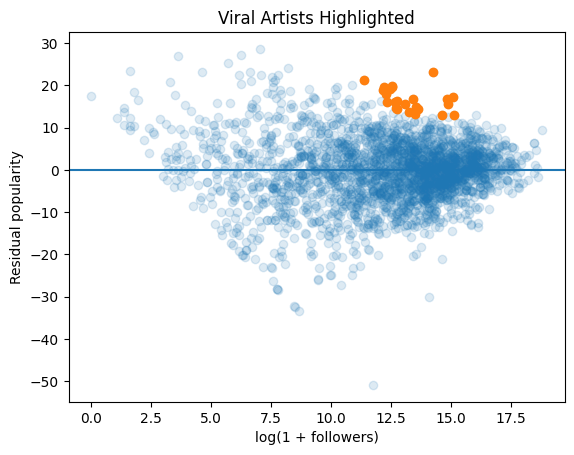

In [25]:
viral = artist_data[(artist_data["z"] >= 2) & (artist_data["artist_popularity"] >= 70)]

plt.figure()
plt.scatter(artist_data["log_followers"], artist_data["residual"], alpha=0.15)
plt.scatter(viral["log_followers"], viral["residual"])
plt.axhline(0)
plt.xlabel("log(1 + followers)")
plt.ylabel("Residual popularity")
plt.title("Viral Artists Highlighted")
plt.show()


These plots show residual popularity against log-transformed follower count after removing the average relationship between followers and popularity.

Residuals are centered around zero across all follower sizes, indicating that the effect of audience size has been successfully removed. Popularity is no longer mechanically driven by follower count, which validates the expected-popularity baseline.